In [1]:
# ✅ Instalación de librerías
!pip install -q transformers datasets peft bitsandbytes accelerate gradio


In [2]:
# ✅ Importación de librerías
import torch
import pandas as pd
from datasets import Dataset
from transformers import (
    AutoModelForCausalLM,
    AutoTokenizer,
    BitsAndBytesConfig,
    TrainingArguments,
    Trainer,
    DataCollatorForLanguageModeling
)
from peft import PromptTuningConfig, get_peft_model, prepare_model_for_kbit_training


In [3]:
import pandas as pd

# Lista de ejemplos
data = [
    {
        "input": "700 mil millones para tren elevado en la costa Caribe",
        "output": "ECONOMÍA: Esta inversión mejora la conectividad regional, reduce costos logísticos y genera retornos a largo plazo vía aumento de productividad.\nPOLÍTICA: Se promueve la equidad territorial al integrar regiones históricamente marginadas. Genera empleo directo en la construcción.\nCRÍTICA: El costo es elevado para una región con baja densidad urbana. Riesgo de elefante blanco si no se garantiza demanda."
    },
    {
        "input": "500 mil millones para subsidios a paneles solares en zonas rurales",
        "output": "ECONOMÍA: Disminuye la dependencia de combustibles fósiles, reduce el gasto en energía y promueve desarrollo económico local.\nPOLÍTICA: Empodera comunidades apartadas, mejora calidad de vida y es coherente con compromisos climáticos.\nCRÍTICA: Alta inversión por hogar beneficiado. Hay dudas sobre mantenimiento y capacitación técnica local."
    },
    {
        "input": "300 mil millones para ampliar la jornada escolar completa en colegios públicos",
        "output": "ECONOMÍA: Mejora el capital humano, eleva la productividad futura y reduce costos sociales como el crimen.\nPOLÍTICA: Contribuye a la equidad educativa. Apoya a madres cabeza de familia al liberar tiempo de cuidado.\nCRÍTICA: Puede ser costoso sin asegurar calidad educativa. Se requiere más que tiempo adicional para mejorar resultados."
    },
    {
        "input": "1 billón para el metro subterráneo de Bogotá",
        "output": "ECONOMÍA: Genera ahorros en tiempo, reduce congestión y contaminación. Aumenta valorización urbana.\nPOLÍTICA: Es una deuda histórica con la ciudad. Moderniza la infraestructura nacional.\nCRÍTICA: Riesgo de sobrecostos. Experiencia internacional muestra retrasos. Se compromete capacidad de endeudamiento nacional."
    },
    {
        "input": "250 mil millones para renovar hospitales en la Amazonía",
        "output": "ECONOMÍA: Mejora la eficiencia del sistema de salud y reduce los costos de atención tardía o evacuación aérea.\nPOLÍTICA: Fortalece la presencia estatal en zonas olvidadas. Aumenta legitimidad institucional.\nCRÍTICA: Difícil supervisión y riesgos de corrupción. Posible subutilización por baja densidad poblacional."
    },
    {
        "input": "150 mil millones para crear una universidad pública en Chocó",
        "output": "ECONOMÍA: Genera capital humano local, reduce migración de jóvenes y estimula el desarrollo endógeno.\nPOLÍTICA: Apuesta por la justicia racial y territorial. Cierra brechas históricas en educación superior.\nCRÍTICA: Alto costo por estudiante. Dudas sobre calidad y empleabilidad de egresados."
    },
    {
        "input": "120 mil millones para subsidios de conectividad a internet en zonas rurales",
        "output": "ECONOMÍA: Facilita el acceso a mercados, educación y salud digital. Mejora la productividad agrícola e inclusión financiera.\nPOLÍTICA: Cierra la brecha digital rural-urbana. Fortalece la ciudadanía digital.\nCRÍTICA: Posibles contratos inflados. Sin alfabetización digital, la infraestructura es poco útil."
    },
    {
        "input": "900 mil millones para ampliar autopistas en los Llanos Orientales",
        "output": "ECONOMÍA: Mejora exportación agrícola y ganadera. Reduce tiempos y costos de transporte.\nPOLÍTICA: Potencia una región clave para el desarrollo económico del país.\nCRÍTICA: Incentiva deforestación. Puede beneficiar grandes terratenientes más que pequeños productores."
    },
    {
        "input": "200 mil millones para un centro de innovación tecnológica en Medellín",
        "output": "ECONOMÍA: Promueve la economía del conocimiento, genera startups y empleo calificado.\nPOLÍTICA: Fortalece la reputación de Medellín como ciudad innovadora.\nCRÍTICA: Concentración de recursos en zonas ya desarrolladas. Posible exclusión de talentos de otras regiones."
    },
    {
        "input": "50 mil millones para campaña nacional de reciclaje",
        "output": "ECONOMÍA: Reduce costos de disposición final de residuos y promueve economía circular.\nPOLÍTICA: Concientiza a la población, promueve corresponsabilidad ciudadana.\nCRÍTICA: Bajo impacto si no se acompaña de infraestructura adecuada. Puede verse como medida simbólica."
    },
     {
        "input": "800 mil millones para un aeropuerto regional en Boyacá",
        "output": "ECONOMÍA: Fomenta el turismo y comercio local, mejorando la conectividad y generando ingresos adicionales.\nPOLÍTICA: Desarrollo regional y creación de empleos directos e indirectos.\nCRÍTICA: Potencialmente baja demanda, riesgo de convertirse en infraestructura subutilizada."
    },
    {
        "input": "400 mil millones para renovación urbana en el centro histórico de Cartagena",
        "output": "ECONOMÍA: Aumenta el turismo y valoriza propiedades cercanas.\nPOLÍTICA: Revitalización cultural y patrimonial.\nCRÍTICA: Posibles efectos de gentrificación y desplazamiento de residentes tradicionales."
    },
    {
        "input": "350 mil millones para becas universitarias para comunidades indígenas",
        "output": "ECONOMÍA: Formación de capital humano especializado, impulso a largo plazo en productividad.\nPOLÍTICA: Justicia social, reducción de brechas históricas.\nCRÍTICA: Requiere acompañamiento integral para evitar deserción."
    },
    {
        "input": "100 mil millones para campañas de seguridad vial",
        "output": "ECONOMÍA: Reduce accidentes y gastos en salud pública.\nPOLÍTICA: Mejora la percepción ciudadana sobre seguridad pública.\nCRÍTICA: Puede ser inefectivo sin infraestructura vial adecuada."
    },
    {
        "input": "600 mil millones para construcción de viviendas sociales en Cali",
        "output": "ECONOMÍA: Impulsa construcción y empleo local, mejora calidad de vida.\nPOLÍTICA: Combate la pobreza y déficit habitacional.\nCRÍTICA: Riesgo de corrupción en adjudicación de contratos."
    },
    {
        "input": "450 mil millones para digitalización del archivo nacional",
        "output": "ECONOMÍA: Acceso eficiente a información histórica y reducción de costos operativos.\nPOLÍTICA: Transparencia gubernamental y preservación cultural.\nCRÍTICA: Alto costo inicial, posibles retrasos por fallos técnicos."
    },
    {
        "input": "80 mil millones para parques infantiles en municipios pequeños",
        "output": "ECONOMÍA: Promueve turismo local y pequeños negocios cercanos.\nPOLÍTICA: Espacios seguros de recreación infantil.\nCRÍTICA: Bajo impacto económico real, prioridad discutible frente a otras necesidades."
    },
    {
        "input": "2 billones para renovación del sistema ferroviario nacional",
        "output": "ECONOMÍA: Eficiencia logística, reducción de costos de transporte.\nPOLÍTICA: Integración territorial y reducción de emisiones.\nCRÍTICA: Altísimos costos iniciales, dudas sobre rentabilidad y sostenibilidad."
    },
    {
        "input": "300 mil millones para subsidios al transporte público en Bogotá",
        "output": "ECONOMÍA: Reduce costos para usuarios, fomenta uso de transporte público.\nPOLÍTICA: Equidad y accesibilidad urbana.\nCRÍTICA: Sostenibilidad fiscal dudosa, dependencia permanente de subsidios."
    },
    {
        "input": "100 mil millones para restauración ecológica en páramos",
        "output": "ECONOMÍA: Protege fuentes hídricas vitales para sectores económicos clave.\nPOLÍTICA: Compromiso ambiental y mitigación del cambio climático.\nCRÍTICA: Dificultad para medir resultados concretos a corto plazo."
    },
    {
        "input": "550 mil millones para hospitales móviles para zonas rurales",
        "output": "ECONOMÍA: Reduce costos por atención médica tardía, eficiencia operativa.\nPOLÍTICA: Mejora cobertura y acceso a salud rural.\nCRÍTICA: Alto costo de mantenimiento, riesgo de subutilización."
    },
    {
        "input": "180 mil millones para promoción internacional del turismo colombiano",
        "output": "ECONOMÍA: Incremento de divisas, desarrollo económico regional.\nPOLÍTICA: Mejora imagen país, impulsa diplomacia cultural.\nCRÍTICA: Posibles resultados limitados sin seguridad ni infraestructura turística adecuada."
    },
    {
        "input": "50 mil millones para formación tecnológica de docentes",
        "output": "ECONOMÍA: Mejora calidad educativa, productividad futura.\nPOLÍTICA: Modernización del sector educativo.\nCRÍTICA: Requiere seguimiento continuo para asegurar impacto real."
    },
    {
        "input": "220 mil millones para ampliar cobertura de agua potable en La Guajira",
        "output": "ECONOMÍA: Reduce costos sociales, mejora condiciones de salud pública.\nPOLÍTICA: Justicia social, cumplimiento de derechos humanos básicos.\nCRÍTICA: Riesgos logísticos y corrupción en zonas difíciles."
    },
    {
        "input": "700 mil millones para puentes viales en Antioquia",
        "output": "ECONOMÍA: Reduce tiempos y costos de transporte, aumenta comercio regional.\nPOLÍTICA: Conectividad y desarrollo regional equilibrado.\nCRÍTICA: Riesgo ambiental en zonas de alta biodiversidad."
    },
    {
        "input": "90 mil millones para sistemas de monitoreo sísmico nacional",
        "output": "ECONOMÍA: Previene pérdidas millonarias por desastres.\nPOLÍTICA: Seguridad ciudadana, reducción de riesgos.\nCRÍTICA: Alto costo relativo frente a otros métodos de prevención."
    },
    {
        "input": "270 mil millones para impulsar producción cinematográfica nacional",
        "output": "ECONOMÍA: Genera empleo en industria creativa, ingresos por exportaciones culturales.\nPOLÍTICA: Preservación cultural y posicionamiento internacional.\nCRÍTICA: Beneficio limitado para sectores económicos clave."
    },
    {
        "input": "130 mil millones para renovación tecnológica en colegios públicos",
        "output": "ECONOMÍA: Incrementa competencias digitales, productividad futura.\nPOLÍTICA: Equidad educativa, modernización tecnológica.\nCRÍTICA: Obsolescencia rápida, mantenimiento costoso."
    },
    {
        "input": "60 mil millones para museos regionales de historia natural",
        "output": "ECONOMÍA: Turismo educativo y cultural, desarrollo local.\nPOLÍTICA: Preservación de patrimonio natural.\nCRÍTICA: Bajo retorno económico, potencial baja afluencia."
    },
    {
        "input": "750 mil millones para ampliación de puertos marítimos",
        "output": "ECONOMÍA: Incrementa capacidad exportadora, reduce costos logísticos.\nPOLÍTICA: Fortalecimiento del comercio internacional.\nCRÍTICA: Riesgo ambiental y conflictos territoriales potenciales."
    },
    {
        "input": "600 mil millones para construir plantas de tratamiento de aguas residuales",
        "output": "ECONOMÍA: Mejora la salud pública, reduciendo gastos sanitarios y aumentando la productividad laboral.\nPOLÍTICA: Refuerza el compromiso con el medio ambiente y los ODS.\nCRÍTICA: Costos operativos elevados, riesgos de subutilización si no hay mantenimiento continuo."
    },
    {
        "input": "200 mil millones para fortalecer escuelas rurales con bibliotecas digitales",
        "output": "ECONOMÍA: Cierre de brechas educativas que afecta el desarrollo económico rural.\nPOLÍTICA: Promueve la equidad territorial y el acceso a oportunidades.\nCRÍTICA: Puede no tener impacto si no se acompaña de conectividad y formación docente."
    },
    {
        "input": "1 billón para duplicar la capacidad de la Refinería de Cartagena",
        "output": "ECONOMÍA: Aumenta la producción energética y reduce importaciones de combustibles.\nPOLÍTICA: Soberanía energética y fortalecimiento del sector estratégico.\nCRÍTICA: Contradice metas de descarbonización, riesgo ambiental en zona costera."
    },
    {
        "input": "150 mil millones para desarrollar software educativo público",
        "output": "ECONOMÍA: Reducción de costos en licencias privadas y fortalecimiento del sector tecnológico.\nPOLÍTICA: Democratiza el acceso a la tecnología educativa.\nCRÍTICA: Requiere alta calidad y soporte técnico continuo para ser efectivo."
    },
    {
        "input": "75 mil millones para construir centros deportivos municipales",
        "output": "ECONOMÍA: Estimula empleo en construcción y turismo local por eventos deportivos.\nPOLÍTICA: Fomenta salud y cohesión social.\nCRÍTICA: Pueden volverse elefantes blancos si no hay programas de uso continuo."
    },
    {
        "input": "90 mil millones para modernizar estaciones meteorológicas",
        "output": "ECONOMÍA: Mejora predicción climática y planificación agrícola.\nPOLÍTICA: Refuerza gestión del riesgo y cumplimiento ambiental.\nCRÍTICA: Poco visible para la ciudadanía, difícil de justificar políticamente."
    },
    {
        "input": "400 mil millones para crear un sistema nacional de trenes de carga",
        "output": "ECONOMÍA: Reduce costos logísticos, descongestiona carreteras y mejora competitividad.\nPOLÍTICA: Fortalece integración interregional y sostenibilidad del transporte.\nCRÍTICA: Altísimo costo inicial y riesgo de corrupción en contratos de infraestructura."
    },
    {
        "input": "130 mil millones para un fondo de apoyo a artistas y creadores independientes",
        "output": "ECONOMÍA: Impulsa economía creativa y genera empleos no tradicionales.\nPOLÍTICA: Visibiliza expresiones culturales marginadas y fortalece identidad nacional.\nCRÍTICA: Dificultad para medir impacto económico y riesgo de politización en asignaciones."
    },
    {
        "input": "250 mil millones para un fondo de innovación en energías limpias",
        "output": "ECONOMÍA: Atrae inversión privada y acelera la transición energética.\nPOLÍTICA: Cumple compromisos climáticos y posiciona al país como líder verde.\nCRÍTICA: Alta incertidumbre tecnológica, resultados a largo plazo."
    },
    {
        "input": "180 mil millones para fortalecer el sistema carcelario",
        "output": "ECONOMÍA: Mejora eficiencia en justicia penal y reduce reincidencia a mediano plazo.\nPOLÍTICA: Responde a demandas de seguridad ciudadana.\nCRÍTICA: Puede percibirse como priorizar castigo sobre prevención social."
    },
    {
        "input": "60 mil millones para formación en habilidades digitales para adultos mayores",
        "output": "ECONOMÍA: Mejora inclusión financiera y acceso a servicios públicos digitales.\nPOLÍTICA: Favorece la equidad intergeneracional y el envejecimiento activo.\nCRÍTICA: Bajo impacto económico directo, difícil de escalar sin acompañamiento personalizado."
    },
    {
        "input": "900 mil millones para nuevo centro internacional de convenciones en Medellín",
        "output": "ECONOMÍA: Aumenta turismo de negocios, genera empleo formal y dinamiza sectores hoteleros.\nPOLÍTICA: Posiciona a Medellín como capital de eventos regional.\nCRÍTICA: Posible saturación de infraestructura, desplazamiento de recursos desde necesidades básicas."
    },
    {
        "input": "500 mil millones para dotación tecnológica del Ejército Nacional",
        "output": "ECONOMÍA: Estimula industria de defensa, transferencia tecnológica y empleo especializado.\nPOLÍTICA: Refuerza control territorial y seguridad nacional.\nCRÍTICA: Cuestionamientos éticos, uso indebido y opacidad en compras militares."
    },
    {
        "input": "210 mil millones para programa de alfabetización ambiental en colegios",
        "output": "ECONOMÍA: Forma ciudadanos más responsables con recursos naturales.\nPOLÍTICA: Inversión educativa alineada con sostenibilidad.\nCRÍTICA: Resultados intangibles, difícil medición de impacto."
    },
    {
        "input": "300 mil millones para renovación de cableados eléctricos en zonas urbanas",
        "output": "ECONOMÍA: Reduce pérdidas técnicas, mejora eficiencia energética y confiabilidad del sistema.\nPOLÍTICA: Mejora la percepción de calidad del servicio público.\nCRÍTICA: Alta inversión poco visible para usuarios finales."
    },
    {
        "input": "170 mil millones para digitalización de la justicia civil",
        "output": "ECONOMÍA: Reduce costos procesales y mejora tiempos judiciales.\nPOLÍTICA: Refuerza acceso a justicia y transparencia institucional.\nCRÍTICA: Brecha digital puede excluir a los más vulnerables del sistema."
    },
    {
        "input": "140 mil millones para estrategia nacional de salud mental",
        "output": "ECONOMÍA: Reduce pérdida de productividad y gastos hospitalarios crónicos.\nPOLÍTICA: Aumenta el bienestar general, reduce violencia y exclusión.\nCRÍTICA: Requiere personal altamente capacitado y sostenibilidad presupuestal."
    },
    {
        "input": "220 mil millones para programa nacional de compostaje urbano",
        "output": "ECONOMÍA: Disminuye presión sobre rellenos sanitarios y crea cadenas de valor ambiental.\nPOLÍTICA: Educación ciudadana y cambio de hábitos ecológicos.\nCRÍTICA: Baja adopción sin incentivos directos, requiere fuerte pedagogía."
    },
    {
        "input": "320 mil millones para un sistema unificado de transporte metropolitano",
        "output": "ECONOMÍA: Disminuye duplicidades operativas y mejora eficiencia del servicio.\nPOLÍTICA: Integra regiones, mejora movilidad urbana.\nCRÍTICA: Alta complejidad política y técnica en su implementación."
    },
    {
        "input": "95 mil millones para programa nacional de voluntariado joven",
        "output": "ECONOMÍA: Experiencia laboral temprana, promueve participación social activa.\nPOLÍTICA: Construcción de ciudadanía, prevención de violencia juvenil.\nCRÍTICA: Dificultad para medir impacto, riesgo de baja participación sin incentivos."
    },
    {
        "input": "350 mil millones para fortalecer centros de salud mental comunitarios",
        "output": "ECONOMÍA: Mejora el acceso temprano a tratamientos, reduce costos hospitalarios crónicos y mejora la productividad laboral.\nPOLÍTICA: Responde a una necesidad creciente pospandemia, promueve bienestar colectivo y reduce estigmas.\nCRÍTICA: Requiere personal capacitado y continuidad presupuestal para sostenibilidad."
    },
    {
        "input": "200 mil millones para impulsar energías mareomotrices en el Pacífico colombiano",
        "output": "ECONOMÍA: Aprovecha un recurso natural poco explotado, diversifica la matriz energética y genera innovación.\nPOLÍTICA: Posiciona a Colombia como líder en transición energética en la región.\nCRÍTICA: Tecnología incipiente, altos costos iniciales y falta de infraestructura complementaria."
    },
    {
        "input": "150 mil millones para traducción digital de patrimonio cultural indígena",
        "output": "ECONOMÍA: Impulsa la economía creativa local y genera oportunidades para comunidades marginadas.\nPOLÍTICA: Preserva lenguas y tradiciones en riesgo de desaparición, fomenta inclusión cultural.\nCRÍTICA: Impacto económico incierto, requiere procesos participativos sensibles."
    },
    {
        "input": "800 mil millones para cableado subterráneo de redes eléctricas en zonas urbanas",
        "output": "ECONOMÍA: Disminuye pérdidas técnicas, mejora continuidad del servicio y reduce costos por mantenimiento.\nPOLÍTICA: Moderniza infraestructura urbana, refuerza imagen de ciudades sostenibles.\nCRÍTICA: Inversión elevada, obras pueden generar molestias temporales a la ciudadanía."
    },
    {
        "input": "500 mil millones para expansión del transporte fluvial en la Amazonía",
        "output": "ECONOMÍA: Reduce costos logísticos en regiones de difícil acceso, mejora eficiencia del comercio regional.\nPOLÍTICA: Fortalece integración territorial y mejora acceso a servicios esenciales.\nCRÍTICA: Riesgo de impactos ambientales si no se regula adecuadamente el tráfico fluvial."
    },
    {
        "input": "520 mil millones para centros de innovación rural y tecnología agrícola",
        "output": "ECONOMÍA: Reduce costos operativos a largo plazo.\nPOLÍTICA: Promueve inclusión social y territorial.\nCRÍTICA: Alto costo inicial y dependencia tecnológica."
    },
    {
        "input": "180 mil millones para ampliar cobertura de jardines infantiles en zonas rurales",
        "output": "ECONOMÍA: Fortalece la competitividad regional.\nPOLÍTICA: Refuerza políticas públicas de desarrollo sostenible.\nCRÍTICA: Puede generar desigualdades si no se distribuye equitativamente."
    },
    {
        "input": "1 billón para automatizar el catastro nacional",
        "output": "ECONOMÍA: Aumenta el acceso equitativo a recursos económicos.\nPOLÍTICA: Refuerza políticas públicas de desarrollo sostenible.\nCRÍTICA: Riesgo de baja adopción si no hay pedagogía adecuada."
    },
    {
        "input": "2.5 billones para centros de innovación rural y tecnología agrícola",
        "output": "ECONOMÍA: Aumenta el acceso equitativo a recursos económicos.\nPOLÍTICA: Fortalece la presencia estatal en regiones estratégicas.\nCRÍTICA: Puede generar desigualdades si no se distribuye equitativamente."
    },
    {
        "input": "75 mil millones para centros de innovación rural y tecnología agrícola",
        "output": "ECONOMÍA: Reduce costos operativos a largo plazo.\nPOLÍTICA: Promueve inclusión social y territorial.\nCRÍTICA: Alto costo inicial y dependencia tecnológica."
    },
    {
        "input": "75 mil millones para capacitar mujeres en tecnologías verdes",
        "output": "ECONOMÍA: Mejora la productividad y genera nuevos empleos.\nPOLÍTICA: Responde a compromisos del gobierno con sectores vulnerables.\nCRÍTICA: Alto costo inicial y dependencia tecnológica."
    },
    {
        "input": "1 billón para creación de observatorios regionales de cambio climático",
        "output": "ECONOMÍA: Aumenta el acceso equitativo a recursos económicos.\nPOLÍTICA: Aumenta la legitimidad institucional.\nCRÍTICA: Resultados intangibles difíciles de medir a corto plazo."
    },
    {
        "input": "250 mil millones para automatizar el catastro nacional",
        "output": "ECONOMÍA: Impulsa la eficiencia de servicios públicos.\nPOLÍTICA: Fortalece la presencia estatal en regiones estratégicas.\nCRÍTICA: Alto costo inicial y dependencia tecnológica."
    },
    {
        "input": "400 mil millones para ampliar cobertura de jardines infantiles en zonas rurales",
        "output": "ECONOMÍA: Reduce costos operativos a largo plazo.\nPOLÍTICA: Refuerza políticas públicas de desarrollo sostenible.\nCRÍTICA: Riesgo de baja adopción si no hay pedagogía adecuada."
    },
    {
        "input": "300 mil millones para creación de observatorios regionales de cambio climático",
        "output": "ECONOMÍA: Aumenta el acceso equitativo a recursos económicos.\nPOLÍTICA: Responde a compromisos del gobierno con sectores vulnerables.\nCRÍTICA: Puede generar desigualdades si no se distribuye equitativamente."
    },
    {
        "input": "1 billón para automatizar el catastro nacional",
        "output": "ECONOMÍA: Mejora la productividad y genera nuevos empleos.\nPOLÍTICA: Fortalece la presencia estatal en regiones estratégicas.\nCRÍTICA: Resultados intangibles difíciles de medir a corto plazo."
    },
    {
        "input": "650 mil millones para centros de innovación rural y tecnología agrícola",
        "output": "ECONOMÍA: Impulsa la eficiencia de servicios públicos.\nPOLÍTICA: Promueve inclusión social y territorial.\nCRÍTICA: Resultados intangibles difíciles de medir a corto plazo."
    },
    {
        "input": "1.2 billones para incentivos a industrias de reutilización de residuos",
        "output": "ECONOMÍA: Reduce costos operativos a largo plazo.\nPOLÍTICA: Aumenta la legitimidad institucional.\nCRÍTICA: Resultados intangibles difíciles de medir a corto plazo."
    },
    {
        "input": "600 mil millones para automatizar el catastro nacional",
        "output": "ECONOMÍA: Fortalece la competitividad regional.\nPOLÍTICA: Promueve inclusión social y territorial.\nCRÍTICA: Puede generar desigualdades si no se distribuye equitativamente."
    },
    {
        "input": "520 mil millones para automatizar el catastro nacional",
        "output": "ECONOMÍA: Aumenta el acceso equitativo a recursos económicos.\nPOLÍTICA: Responde a compromisos del gobierno con sectores vulnerables.\nCRÍTICA: Riesgo de baja adopción si no hay pedagogía adecuada."
    },
    {
        "input": "520 mil millones para digitalizar registros médicos en hospitales públicos",
        "output": "ECONOMÍA: Mejora la productividad y genera nuevos empleos.\nPOLÍTICA: Fortalece la presencia estatal en regiones estratégicas.\nCRÍTICA: Resultados intangibles difíciles de medir a corto plazo."
    },
    {
        "input": "75 mil millones para implementar bibliotecas móviles en municipios dispersos",
        "output": "ECONOMÍA: Reduce costos operativos a largo plazo.\nPOLÍTICA: Refuerza políticas públicas de desarrollo sostenible.\nCRÍTICA: Riesgo de baja adopción si no hay pedagogía adecuada."
    },
    {
        "input": "90 mil millones para centros de innovación rural y tecnología agrícola",
        "output": "ECONOMÍA: Fortalece la competitividad regional.\nPOLÍTICA: Aumenta la legitimidad institucional.\nCRÍTICA: Riesgo de baja adopción si no hay pedagogía adecuada."
    },
    {
        "input": "120 mil millones para digitalizar registros médicos en hospitales públicos",
        "output": "ECONOMÍA: Reduce costos operativos a largo plazo.\nPOLÍTICA: Fortalece la presencia estatal en regiones estratégicas.\nCRÍTICA: Resultados intangibles difíciles de medir a corto plazo."
    },
    {
        "input": "1 billón para centros de innovación rural y tecnología agrícola",
        "output": "ECONOMÍA: Reduce costos operativos a largo plazo.\nPOLÍTICA: Fortalece la presencia estatal en regiones estratégicas.\nCRÍTICA: Riesgo de baja adopción si no hay pedagogía adecuada."
    },
    {
        "input": "300 mil millones para implementar bibliotecas móviles en municipios dispersos",
        "output": "ECONOMÍA: Fortalece la competitividad regional.\nPOLÍTICA: Fortalece la presencia estatal en regiones estratégicas.\nCRÍTICA: Riesgo de baja adopción si no hay pedagogía adecuada."
    },
    {
        "input": "600 mil millones para digitalizar registros médicos en hospitales públicos",
        "output": "ECONOMÍA: Aumenta el acceso equitativo a recursos económicos.\nPOLÍTICA: Promueve inclusión social y territorial.\nCRÍTICA: Riesgo de baja adopción si no hay pedagogía adecuada."
    },
    {
        "input": "650 mil millones para centros de innovación rural y tecnología agrícola",
        "output": "ECONOMÍA: Fortalece la competitividad regional.\nPOLÍTICA: Promueve inclusión social y territorial.\nCRÍTICA: Resultados intangibles difíciles de medir a corto plazo."
    },
    {
        "input": "1.2 billones para centros de innovación rural y tecnología agrícola",
        "output": "ECONOMÍA: Aumenta el acceso equitativo a recursos económicos.\nPOLÍTICA: Promueve inclusión social y territorial.\nCRÍTICA: Dificultad de seguimiento en zonas aisladas."
    },
    {
        "input": "1 billón para automatizar el catastro nacional",
        "output": "ECONOMÍA: Aumenta el acceso equitativo a recursos económicos.\nPOLÍTICA: Refuerza políticas públicas de desarrollo sostenible.\nCRÍTICA: Riesgo de baja adopción si no hay pedagogía adecuada."
    }

]

# Crear DataFrame
df = pd.DataFrame(data)

# Guardar como CSV
df.to_csv("gasto_justificado.csv", index=False)

print("✅ Archivo 'gasto_justificado.csv' creado correctamente.")


✅ Archivo 'gasto_justificado.csv' creado correctamente.


In [4]:
# ✅ Cargar el dataset desde CSV
df = pd.read_csv("gasto_justificado.csv")
dataset = Dataset.from_pandas(df)
print(f"📊 Dataset cargado con {len(dataset)} ejemplos")


📊 Dataset cargado con 80 ejemplos


In [5]:
# ✅ Tokenizador y Prompt Tuning (system prompt)
model_name = "microsoft/phi-2"
tokenizer = AutoTokenizer.from_pretrained(model_name)

if tokenizer.pad_token is None:
    tokenizer.pad_token = tokenizer.eos_token
tokenizer.padding_side = "right"

system_prompt = "Eres un asesor experto. Justifica partidas de gasto en términos económicos, políticos y críticos."


In [6]:
# ✅ Preprocesamiento que concatena input + output (entrenamiento supervisado)
def preprocess_function(examples):
    prompts = []
    for i in range(len(examples["input"])):
        prompt = f"<s>{examples['input'][i]}\n\n{examples['output'][i]}</s>"
        prompts.append(prompt)

    tokenized_inputs = tokenizer(
        prompts,
        truncation=True,
        max_length=512,
        padding="max_length",
        return_tensors="pt"
    )
    tokenized_inputs["labels"] = tokenized_inputs["input_ids"].clone()
    return tokenized_inputs

tokenized_dataset = dataset.map(
    preprocess_function,
    batched=True,
    remove_columns=dataset.column_names
)


Map:   0%|          | 0/80 [00:00<?, ? examples/s]

In [7]:
# ✅ Carga del modelo y configuración de Prompt Tuning con texto inicial
bnb_config = BitsAndBytesConfig(
    load_in_8bit=True,
    bnb_8bit_use_double_quant=True,
    bnb_8bit_quant_type="nf4",
    bnb_8bit_compute_dtype=torch.float16
)

model = AutoModelForCausalLM.from_pretrained(
    model_name,
    quantization_config=bnb_config,
    device_map="auto"
)

model = prepare_model_for_kbit_training(model)

peft_config = PromptTuningConfig(
    task_type="CAUSAL_LM",
    num_virtual_tokens=10,
    tokenizer_name_or_path=model_name,
    prompt_tuning_init="TEXT",
    prompt_tuning_init_text=system_prompt
)

model = get_peft_model(model, peft_config)
model.print_trainable_parameters()


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

trainable params: 25,600 || all params: 2,779,709,440 || trainable%: 0.0009


Map:   0%|          | 0/80 [00:00<?, ? examples/s]

No label_names provided for model class `PeftModelForCausalLM`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.


🚀 Entrenando modelo...


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`.
/usr/local/lib/python3.11/dist-packages/torch/_dynamo/eval_frame.py:745: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. In version 2.5 we will raise an exception if use_reentrant is not passed. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  return fn(*args, **kwargs)
/usr/local/lib/python3.11/dist-packages/bitsandbytes/autograd/_functions.py:315: UserWarning: MatMul8bitLt: inputs will be cast from torch.float32 to float16 during quantization
  warnings.warn(f"MatMul8bitLt: inputs will be cast from {A.dtype} to float16 during quantization")


Step,Training Loss
5,2.736600
10,2.790900
15,2.711600
20,2.650500
25,2.660000
30,2.622700


/usr/local/lib/python3.11/dist-packages/torch/_dynamo/eval_frame.py:745: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. In version 2.5 we will raise an exception if use_reentrant is not passed. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  return fn(*args, **kwargs)
/usr/local/lib/python3.11/dist-packages/bitsandbytes/autograd/_functions.py:315: UserWarning: MatMul8bitLt: inputs will be cast from torch.float32 to float16 during quantization
  warnings.warn(f"MatMul8bitLt: inputs will be cast from {A.dtype} to float16 during quantization")


✅ Entrenamiento finalizado.


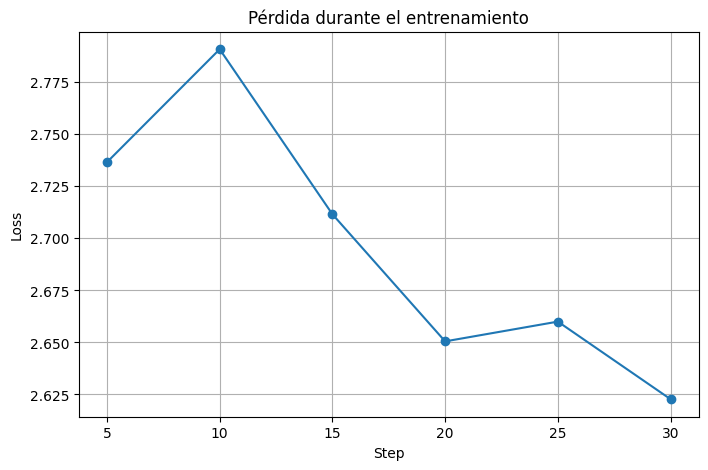

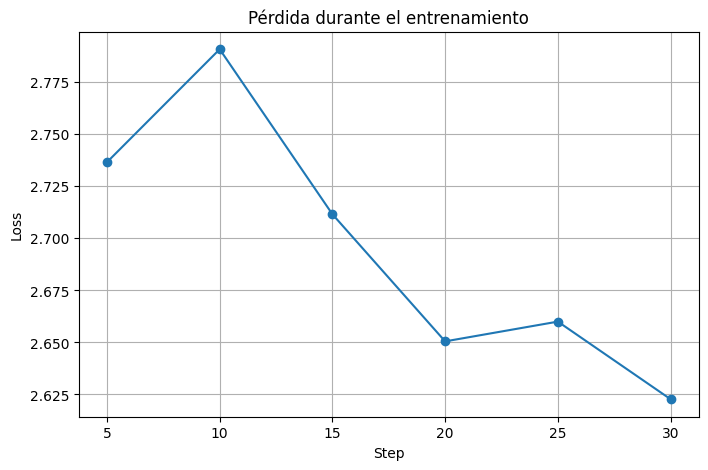

In [8]:
from transformers import TrainingArguments, Trainer, TrainerCallback
from transformers import DataCollatorForLanguageModeling
import matplotlib.pyplot as plt

# ====== AJUSTE DE DATASET PARA TRAINER ======
# Convertimos explícitamente las labels a listas simples para que Trainer las detecte correctamente.
def format_labels(example):
    example["labels"] = example["input_ids"]
    return example

tokenized_dataset = tokenized_dataset.map(format_labels)

# ====== CONFIGURACIÓN DEL ENTRENAMIENTO ======
training_args = TrainingArguments(
    output_dir="./resultados_justificador_phi2",
    per_device_train_batch_size=2,
    gradient_accumulation_steps=4,
    num_train_epochs=3,
    warmup_steps=10,
    learning_rate=2e-4,
    fp16=True,
    logging_steps=5,
    save_steps=20,
    save_total_limit=1,
    report_to="none"
)

# Callback personalizado para graficar la pérdida
class LossCallback(TrainerCallback):
    def __init__(self):
        self.losses = []
        self.steps = []

    def on_log(self, args, state, control, logs=None, **kwargs):
        if logs and "loss" in logs:
            self.losses.append(logs["loss"])
            self.steps.append(state.global_step)

    def plot_loss(self):
        plt.figure(figsize=(8,5))
        plt.plot(self.steps, self.losses, marker='o')
        plt.title("Pérdida durante el entrenamiento")
        plt.xlabel("Step")
        plt.ylabel("Loss")
        plt.grid()
        plt.show()

# Instanciamos el callback
loss_callback = LossCallback()

# Collator para lenguaje causal (no enmascarado)
data_collator = DataCollatorForLanguageModeling(
    tokenizer=tokenizer,
    mlm=False
)

# Trainer (SIN usar label_names para evitar error)
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_dataset,
    data_collator=data_collator,
    callbacks=[loss_callback]
)

# Entrenamos el modelo
print("🚀 Entrenando modelo...")
trainer.train()
print("✅ Entrenamiento finalizado.")

# Graficamos la pérdida
loss_callback.plot_loss()

loss_callback.plot_loss()



In [9]:
# ✅ Inferencia: Solo con el input, el modelo debe generar la justificación
def infer(text):
    prompt = f"<s>{text}\n\n"
    inputs = tokenizer(prompt, return_tensors="pt").to(model.device)
    outputs = model.generate(
        **inputs,
        max_new_tokens=200,
        do_sample=True,
        top_k=50,
        top_p=0.95,
        temperature=0.8
    )
    print(tokenizer.decode(outputs[0], skip_special_tokens=True))

# Ejemplo:
infer("700 mil millones para tren elevado en la costa Caribe")


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
/usr/local/lib/python3.11/dist-packages/peft/peft_model.py:1926: UserWarning: Position ids are not supported for parameter efficient tuning. Ignoring position ids.
  warnings.warn("Position ids are not supported for parameter efficient tuning. Ignoring position ids.")
/usr/local/lib/python3.11/dist-packages/torch/_dynamo/eval_frame.py:745: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. In version 2.5 we will raise an exception if use_reentrant is not passed. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  return fn(*args, **kwargs)
/usr/local/lib/python3.11/dist-packages/torch/utils/checkpoint.py:87: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(
/usr/local/lib/pyth

<s>700 mil millones para tren elevado en la costa Caribe





In [10]:
# Crear carpeta para guardar el modelo
output_dir = "./modelo_justificador_phi2"

# Guardar modelo fine-tuneado (LoRA)
print("💾 Guardando modelo y tokenizador adaptados con LoRA...")
model.save_pretrained(output_dir)
tokenizer.save_pretrained(output_dir)

print(f"✅ Modelo y tokenizador guardados exitosamente en: {output_dir}")

💾 Guardando modelo y tokenizador adaptados con LoRA...
✅ Modelo y tokenizador guardados exitosamente en: ./modelo_justificador_phi2


In [11]:
import gradio as gr
import torch

# Cargar el modelo entrenado y el tokenizador desde disco
output_dir = "./modelo_justificador_phi2"
from transformers import AutoTokenizer, AutoModelForCausalLM
from peft import PeftModel

print("📦 Cargando modelo y tokenizador entrenados...")
tokenizer = AutoTokenizer.from_pretrained(output_dir)
base_model = AutoModelForCausalLM.from_pretrained("microsoft/phi-2", device_map="auto", torch_dtype=torch.float16)
model = PeftModel.from_pretrained(base_model, output_dir)

# Función de generación
def generar_justificacion(texto, max_length=400):
    if not texto.strip():
        return "Por favor ingresa una partida de gasto público."

    prompt = f"<s>Genera una justificación para la siguiente partida de gasto:\n\n{texto}\n\nECONOMÍA:\n"
    inputs = tokenizer(prompt, return_tensors="pt").to(model.device)

    with torch.no_grad():
        outputs = model.generate(
            input_ids=inputs.input_ids,
            attention_mask=inputs.attention_mask,
            max_length=max_length,
            temperature=0.7,
            top_p=0.9,
            do_sample=True,
            pad_token_id=tokenizer.eos_token_id
        )

    generado = tokenizer.decode(outputs[0], skip_special_tokens=True)
    return generado.replace(prompt, "").strip()

# Crear la interfaz Gradio
demo = gr.Interface(
    fn=generar_justificacion,
    inputs=gr.Textbox(label="Partida de gasto público", placeholder="Ejemplo: 700 mil millones para tren elevado en la costa Caribe"),
    outputs=gr.Textbox(label="Justificación generada"),
    title="🧠 Generador de Justificaciones de Gasto Público",
    description="Introduce una partida de gasto y obtén una justificación económica, una narrativa política y una crítica de oposición.",
    examples=[
        ["700 mil millones para tren elevado en la costa Caribe"],
        ["350 mil millones para becas universitarias para comunidades indígenas"],
        ["100 mil millones para restauración ecológica en páramos"],
        ["2 billones para renovación del sistema ferroviario nacional"]
    ],
    theme=gr.themes.Soft()
)

# Lanzar la app
demo.launch(share=True)  # share=True te da un link público




📦 Cargando modelo y tokenizador entrenados...


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://f4a78671889921041a.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)
